# Скрипт для проведения кластеризации

Данный скрипт позволяет выполнить иерархическую кластеризацию и методом k-средних. Для выполнения кластеризации замените только название файла и количество кластеров, которые планируете найти.

Обратите внимание на комментарии с восклицательными знаками, как правило, в этих места надо изменить параметр.

В данном примере используется сокращенный набор данных с сайта https://www.wildberries.ru/, категория чайники. 

Случай, когда мы моделируем данные для того, чтобы обнаружить, как они группируются, на основе определенных атрибутов, является Unsupervised Learning.

Методы кластеризации в ноутуке - кластеризация на основе разделов - k means, иерархическая кластеризация - hierarchical clustering

1. Разбиение: n объектов группируются в k ≤ n разобщенных кластеров.
   Методы разбиения основаны на измерении расстояния, в них применяется итерационное перемещение до тех пор, пока не будет минимизирована некоторая метрика ошибки, основанной на расстоянии.
2. иерархический: пошаговое комбинирование (агломеративное) или разбиение (разделительное) кластеров на основе некоторой меры (расстояние, плотность или непрерывность).


In [33]:
# загрузим библиотеки
# данные библиотеки являются стандартными для пакета Anaconda
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from collections import defaultdict
#данная строчка нужна для корректного отображения графиков
%matplotlib inline 

Ниже нужно изменить имя файла, чтобы загрузить Ваши данные. 

In [2]:
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data['data'],columns=data['feature_names'])
df['target'] = data['target']

df.sample(5) #эта команда выведет пять случайных строк таблицы, таблица не отобразиться полностью.

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
140,6.7,3.1,5.6,2.4,2
10,5.4,3.7,1.5,0.2,0
46,5.1,3.8,1.6,0.2,0
114,5.8,2.8,5.1,2.4,2
40,5.0,3.5,1.3,0.3,0


In [3]:
df.info() # информация о столбцах таблицы и типах меременных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


Attribute Information:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class:
-- Iris Setosa
-- Iris Versicolour
-- Iris Virginica

In [4]:
df.describe() # статистики по столбцам с количественными переменными

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [5]:
df.columns #ниже выводит список столцов, удобно для копирования

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

In [6]:
col=data['feature_names'] # !!!!!! укажите количественные (int, float) столбцы, 
#                                       по которым выполним кластеризацию

In [7]:
pd.options.mode.chained_assignment = None 
df[col].fillna(0, inplace=True) # заменим пропуски данных нулями, в противном случае выдаст ошибку

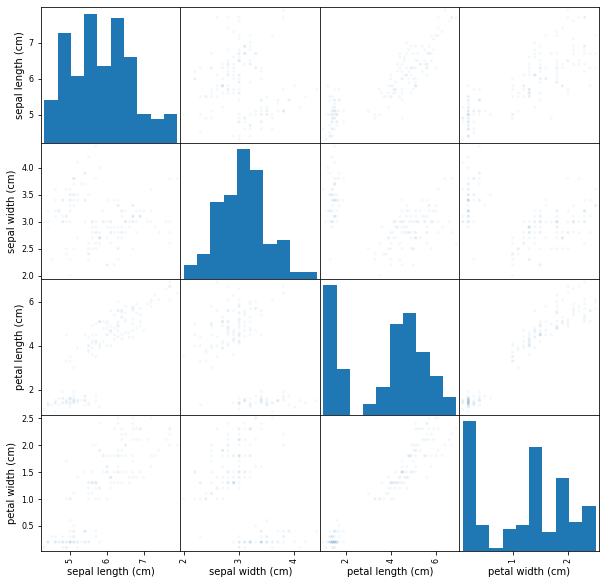

In [8]:
# матрица рассеяния и гистограммы
from pandas.plotting import scatter_matrix
scatter_matrix(df[col], alpha=0.05, figsize=(10, 10));

In [9]:
df[col].corr() # посмотрим на парные корреляции

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


In [10]:
# загружаем библиотеку препроцесинга данных
# эта библиотека автоматически приведен данные к нормальным значениям
from sklearn import preprocessing
dataNorm = preprocessing.MinMaxScaler().fit_transform(df[col].values)

In [11]:
# Вычислим расстояния между каждым набором данных,
# т.е. строками массива data_for_clust
# Вычисляется евклидово расстояние (по умолчанию)
data_dist = pdist(dataNorm, 'euclidean')
# Главная функция иерархической кластеризии
# Объедение элементов в кластера и сохранение в 
# специальной переменной (используется ниже для визуализации 
# и выделения количества кластеров
data_linkage = linkage(data_dist, method='average')

Преимущество локтевого метода
WCSS (в пределах кластера сумма квадратов)
Этот метод удовлетворяет как математическим предпосылкам для кластеризации, так и находит центроид кластера.

Сумма квадратов расстояний каждой точки данных во всех кластерах до их центроидов. Идея состоит в том, чтобы свести эту сумму к минимуму для достижения идеального решения кластеризации.

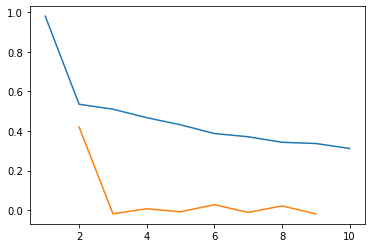

Рекомендованное количество кластеров: 2


In [12]:
# Метод локтя. Позволячет оценить оптимальное количество сегментов.
# Показывает сумму внутри групповых вариаций
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2 
print("Рекомендованное количество кластеров:", k)

Метод локтя - указывает неверное количество классов - на самом деле 3 класса()


In [14]:
#функция построения дендрограмм
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [15]:
# !!!!!!!!! укажите, какое количество кластеров будете использовать!
nClust=3

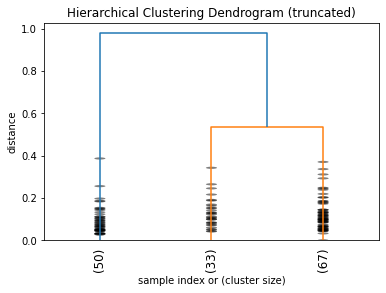

In [16]:
#строим дендрограмму 
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=nClust, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

In [17]:
# иерархическая кластеризация
clusters=fcluster(data_linkage, nClust, criterion='maxclust')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2,
       2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2,
       2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3], dtype=int32)

In [18]:
col

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

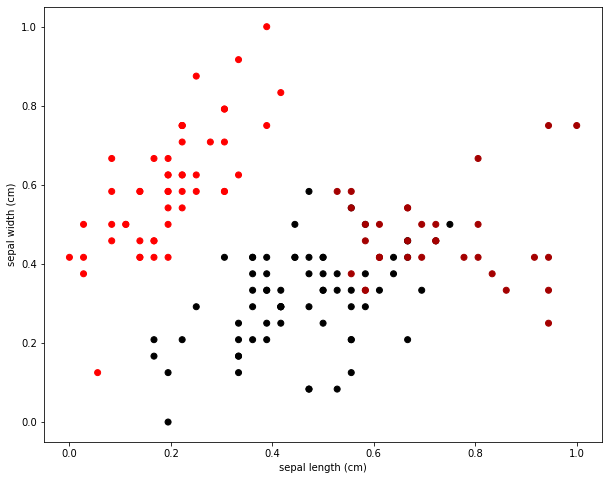

In [19]:
x=0 # Чтобы построить диаграмму в разных осях, меняйте номера столбцов
y=1 #
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=clusters, cmap='flag')
plt.xlabel(col[x])
plt.ylabel(col[y]);
plt.show()

In [20]:
# к оригинальным данным добавляем номер кластера
df['I']=clusters
res=df.groupby('I')[col].mean()
res['Количество']=df.groupby('I').size().values
res #ниже средние цифры по кластерам и количество объектов (Количество)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Количество
I,,,,,
1,5.006000,3.428000,1.462000,0.246000,50
2,6.893939,3.118182,5.806061,2.133333,33
3,5.950746,2.750746,4.462687,1.450746,67


In [21]:
df[df['I']==1] # !!!!! меняйте номер кластера

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,I
0,5.1,3.5,1.4,0.2,0,1
1,4.9,3.0,1.4,0.2,0,1
2,4.7,3.2,1.3,0.2,0,1
3,4.6,3.1,1.5,0.2,0,1
4,5.0,3.6,1.4,0.2,0,1
5,5.4,3.9,1.7,0.4,0,1
6,4.6,3.4,1.4,0.3,0,1
7,5.0,3.4,1.5,0.2,0,1
8,4.4,2.9,1.4,0.2,0,1
9,4.9,3.1,1.5,0.1,0,1


In [22]:
# выводим только некоторые столбцы, меняйте список
df[df['I']==1]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,I
0,5.1,3.5,1.4,0.2,0,1
1,4.9,3.0,1.4,0.2,0,1
2,4.7,3.2,1.3,0.2,0,1
3,4.6,3.1,1.5,0.2,0,1
4,5.0,3.6,1.4,0.2,0,1
5,5.4,3.9,1.7,0.4,0,1
6,4.6,3.4,1.4,0.3,0,1
7,5.0,3.4,1.5,0.2,0,1
8,4.4,2.9,1.4,0.2,0,1
9,4.9,3.1,1.5,0.1,0,1


In [23]:
# строим кластеризаци методом KMeans
km = KMeans(n_clusters=nClust).fit(dataNorm)
y_kmeans = km.fit_predict(data['data'])

In [24]:
# выведем полученное распределение по кластерам
# так же номер кластера, к котрому относится строка, так как нумерация начинается с нуля, выводим добавляя 1
km.labels_ +1

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3], dtype=int32)

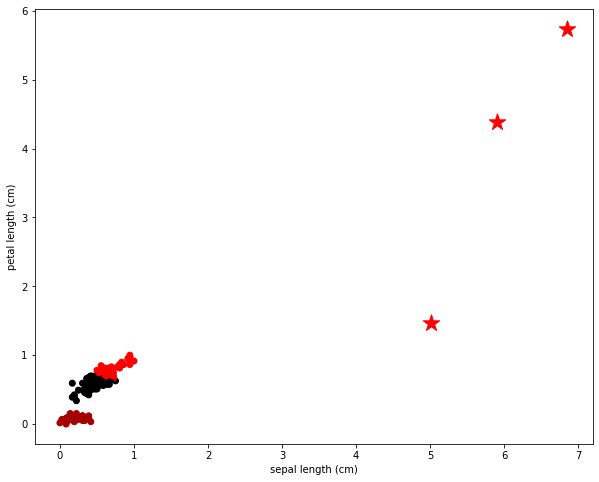

In [25]:
x=0 # Чтобы построить диаграмму в разных осях, меняйте номера столбцов
y=2 #
centroids = km.cluster_centers_
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=km.labels_, cmap='flag')
plt.scatter(centroids[:, x], centroids[:, y], marker='*', s=300,
            c='r', label='centroid')
plt.xlabel(col[x])
plt.ylabel(col[y]);
plt.show()

In [41]:
#cрасвиваем пресказания с оригиналом

Text(0.5, 1.0, 'Predicted')

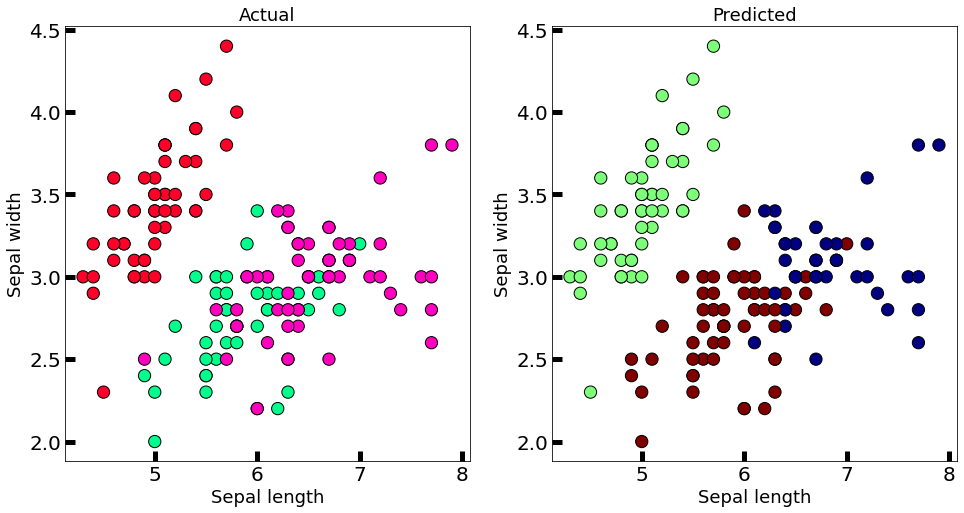

In [40]:
new_labels = km.labels_
X = X_iris
y = y_iris
# Plot the identified clusters and compare with the answers
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='gist_rainbow',
edgecolor='k', s=150)
axes[1].scatter(X[:, 0], X[:, 1], c=new_labels, cmap='jet',
edgecolor='k', s=150)
axes[0].set_xlabel('Sepal length', fontsize=18)
axes[0].set_ylabel('Sepal width', fontsize=18)
axes[1].set_xlabel('Sepal length', fontsize=18)
axes[1].set_ylabel('Sepal width', fontsize=18)
axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Predicted', fontsize=18)

In [43]:
# к оригинальным данным добавляем номера кластеров
df['KMeans']=km.labels_+1
res=df.groupby('KMeans')[col].mean()
res['Количество']=df.groupby('KMeans').size().values
res

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Количество
KMeans,,,,,
1,5.006000,3.428000,1.462000,0.246000,50
2,5.888525,2.737705,4.396721,1.418033,61
3,6.846154,3.082051,5.702564,2.079487,39


In [44]:
df[df['KMeans']==3] # изменяйте номер кластера, содержание которого хотите просмотреть

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,I,KMeans
50,7.0,3.2,4.7,1.4,1,3,3
52,6.9,3.1,4.9,1.5,1,3,3
77,6.7,3.0,5.0,1.7,1,3,3
100,6.3,3.3,6.0,2.5,2,2,3
102,7.1,3.0,5.9,2.1,2,2,3
103,6.3,2.9,5.6,1.8,2,2,3
104,6.5,3.0,5.8,2.2,2,2,3
105,7.6,3.0,6.6,2.1,2,2,3
107,7.3,2.9,6.3,1.8,2,2,3
108,6.7,2.5,5.8,1.8,2,3,3


In [46]:
df[df['KMeans']==3]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,I,KMeans
50,7.0,3.2,4.7,1.4,1,3,3
52,6.9,3.1,4.9,1.5,1,3,3
77,6.7,3.0,5.0,1.7,1,3,3
100,6.3,3.3,6.0,2.5,2,2,3
102,7.1,3.0,5.9,2.1,2,2,3
103,6.3,2.9,5.6,1.8,2,2,3
104,6.5,3.0,5.8,2.2,2,2,3
105,7.6,3.0,6.6,2.1,2,2,3
107,7.3,2.9,6.3,1.8,2,2,3
108,6.7,2.5,5.8,1.8,2,3,3


In [47]:
# сохраним результаты в файл
df.to_excel('result_claster.xlsx', index=False)

Выводы





Двухкластерное решение казалось хорошим, но в реальной жизни в наборе данных по радужной оболочке глаза есть 3 вида кластерного решения. Поэтому кластеризации нельзя доверять все время.

Иногда может показаться, что х-образные кластеры - это хорошее решение, но в реальной жизни их больше (или меньше). Оптимальное решение в этой ситуации основано на том, какие метрики и проблемы вы пытаетесь решить. В данном конкретном учебнике ставилась цель создать кластеры на основе числа видов. Таким образом, лучшее количество кластеров для этого набора данных - 3.

Выводы из этого опыта:
Метод "локоть" несовершенен (мы могли бы выбрать 2 или даже 4).
K-средние очень полезны в моменты, когда мы уже знаем количество кластеров - в данном случае: 3.